In [1]:
# Data manipulation
# ==============================================================================\
import pandas as pd 
import numpy as np


# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10


RANDOM_SEED = 1024

In [2]:
df = pd.read_parquet('data/merged_data.parquet')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.loc['2021-01-01':]

n_days_forecast = 1
df['Close_Target'] = df['Close'].shift(-n_days_forecast)

drop_cols = ['Value_Classification']
df.drop(drop_cols, axis=1, inplace=True)
df.dropna(inplace=True)

In [3]:
def lag_features(df, lags):
    for lag in lags:
        df[f'Lag_{lag}'] = df['Close'].shift(lag)
    return df

def add_features(df):
    lags = range(1,11)
    window = 7
    df = lag_features(df, lags)
    df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
    df['Rolling_Std'] = df['Close'].rolling(window=window).std()
    return df

def plot_train_test(X_train, X_test, y_train, y_test):
    plt.figure(figsize=(8, 6))
    plt.plot(X_train.index, y_train, label='Train')
    plt.plot(X_test.index, y_test, label='Test')
    plt.legend()
    plt.title('Crypto Prices Train and Test Split')
    plt.show()

def split_data(X,y,test_size, plot = True):
    N_TRAIN = int(X.shape[0] * (1-test_size))
    X_train, X_test = X[:N_TRAIN], X[N_TRAIN:]
    y_train, y_test = y[:N_TRAIN], y[N_TRAIN:]
    print(f"Train dates : {X_train.index.min()} --- {X_train.index.max()}  (n={len(X_train)})")
    print(f"Test dates  : {X_test.index.min()} --- {X_test.index.max()}  (n={len(X_test)})")
    if plot:
        plot_train_test(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape

def plot_predictions(y_train, y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Test')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.legend()
    plt.title('Crypto Prices True vs Predicted')
    plt.show()

def train_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    return model

In [44]:
df = add_features(df)


target = 'Close_Target'
features = [col for col in df.columns if col != target]

# Convert target to log returns
# df[target] = np.log(df[target]).diff()
df_clean = df.dropna()

X = df_clean[features]
y = df_clean[target]


Train dates : 2021-01-11 00:00:00 --- 2023-03-09 00:00:00  (n=788)
Test dates  : 2023-03-10 00:00:00 --- 2024-02-10 00:00:00  (n=338)


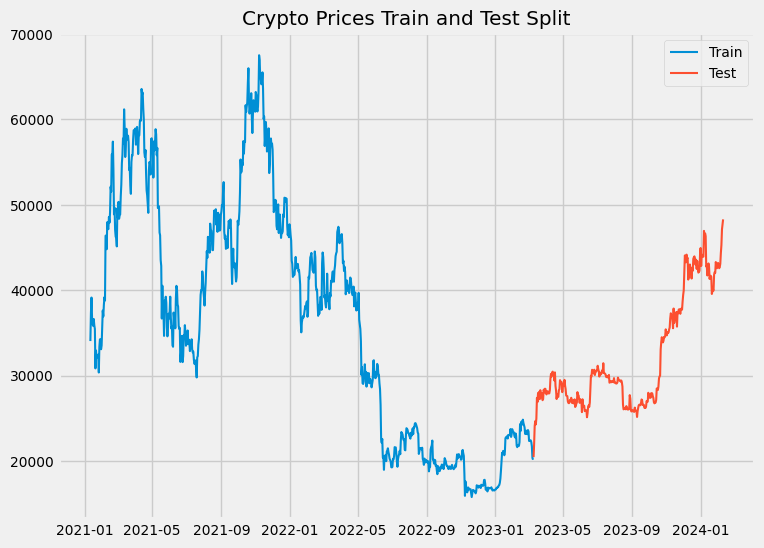

In [45]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3, plot=True)

In [46]:
X_train.head()

,Open,High,Low,Close,Volume,Value,Sentiment_Label,Negative_Percent,Neutral_Percent,Positive_Percent,...,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Rolling_Mean,Rolling_Std
date,,,,,,,,,,,,,,,,,,,,,
2021-01-11,38150.02,38264.74,30420.00,35404.47,251156.138287,90.0,-0.380952,0.571429,0.238095,0.190476,...,40582.81,39432.28,36769.36,33949.53,31988.71,33000.05,32178.33,29331.69,37768.098571,2496.217551
2021-01-12,35410.37,36628.00,32531.00,34051.24,133948.151996,84.0,-0.266667,0.400000,0.466667,0.133333,...,40088.22,40582.81,39432.28,36769.36,33949.53,31988.71,33000.05,32178.33,37782.628571,2470.448887
2021-01-13,34049.15,37850.00,32380.00,37371.38,124477.914938,78.0,-0.086957,0.304348,0.478261,0.217391,...,38150.02,40088.22,40582.81,39432.28,36769.36,33949.53,31988.71,33000.05,37868.631429,2439.581350
2021-01-14,37371.38,40100.00,36701.23,39144.50,102950.389421,83.0,0.437500,0.000000,0.562500,0.437500,...,35404.47,38150.02,40088.22,40582.81,39432.28,36769.36,33949.53,31988.71,37827.520000,2411.097803
2021-01-15,39145.21,39747.76,34408.00,36742.22,118300.920916,88.0,0.250000,0.187500,0.375000,0.437500,...,34051.24,35404.47,38150.02,40088.22,40582.81,39432.28,36769.36,33949.53,37278.864286,2096.006009


Training Ridge...
Ridge Train RMSE: 1462.38
Ridge Test RMSE: 800.47
Ridge Train MAE: 999.71
Ridge Test MAE: 570.04
Ridge Train MAPE: 0.03
Ridge Test MAPE: 0.02


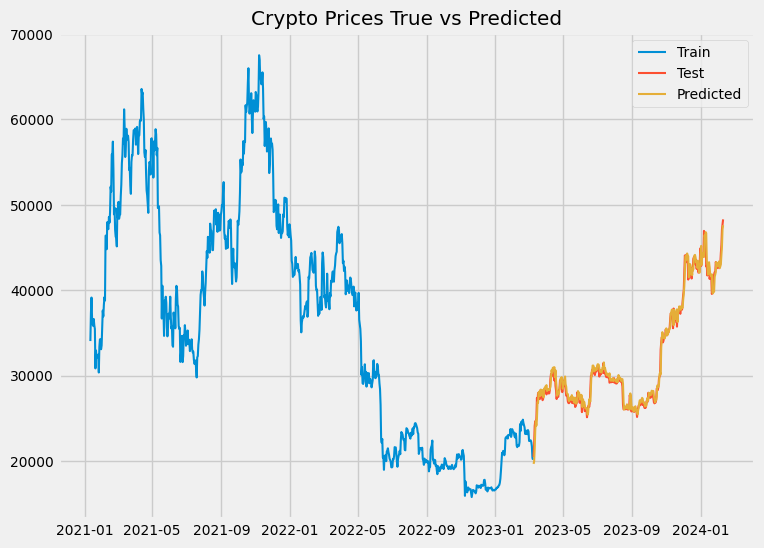




Training RandomForest...
RandomForest Train RMSE: 603.02
RandomForest Test RMSE: 1727.96
RandomForest Train MAE: 407.77
RandomForest Test MAE: 1449.46
RandomForest Train MAPE: 0.01
RandomForest Test MAPE: 0.05


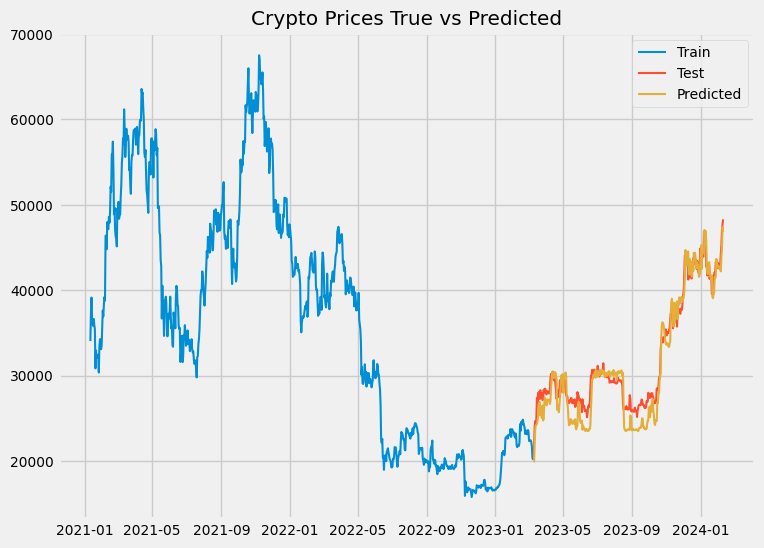

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=0)
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model = train_model(X_train_scaled, y_train, model)
    y_pred_train = pd.Series(model.predict(X_train_scaled), index=X_train.index)
    y_pred_test = pd.Series(model.predict(X_test_scaled), index=X_test.index)
    rmse_train, mae_train, mape_train = evaluate_model(y_train, y_pred_train)
    rmse_test, mae_test, mape_test = evaluate_model(y_test, y_pred_test)
    
    y_pred = pd.concat([y_pred_train, y_pred_test], axis=0).sort_index()
    df[f'Prediction_{model_name}'] = y_pred

    print(f"{model_name} Train RMSE: {rmse_train:.2f}")
    print(f"{model_name} Test RMSE: {rmse_test:.2f}")
    print(f"{model_name} Train MAE: {mae_train:.2f}")
    print(f"{model_name} Test MAE: {mae_test:.2f}")
    print(f"{model_name} Train MAPE: {mape_train:.2f}")
    print(f"{model_name} Test MAPE: {mape_test:.2f}")
    plot_predictions(y_train, y_test, y_pred_test)
    print("\n\n")

In [48]:
df_train = df.loc[X_train.index, ['Close', 'Close_Target', 'Prediction_Ridge', 'Prediction_RandomForest']]
df_test = df.loc[X_test.index, ['Close', 'Close_Target', 'Prediction_Ridge', 'Prediction_RandomForest']]

In [49]:
df_train['returns_real'] = (df_train['Close_Target'] / df_train['Close']) - 1
df_train['returns_ridge'] = (df_train['Prediction_Ridge'] / df_train['Close']) - 1
df_train['returns_rf'] = (df_train['Prediction_RandomForest'] / df_train['Close']) - 1

df_test['returns_real'] = (df_test['Close_Target'] / df_test['Close']) - 1
df_test['returns_ridge'] = (df_test['Prediction_Ridge'] / df_test['Close']) - 1
df_test['returns_rf'] = (df_test['Prediction_RandomForest'] / df_test['Close']) - 1

In [53]:
df_train[['returns_real', 'returns_ridge', 'returns_rf']].describe()

,returns_real,returns_ridge,returns_rf
count,788.000000,788.000000,788.000000
mean,-0.000030,0.000192,0.000168
std,0.036978,0.009061,0.023951
min,-0.153798,-0.035506,-0.098244
25%,-0.017795,-0.005842,-0.011772
50%,-0.000764,-0.000292,-0.000778
75%,0.017829,0.006351,0.012551
max,0.195361,0.038949,0.113355


In [54]:
df_test[['returns_real', 'returns_ridge', 'returns_rf']].describe()

,returns_real,returns_ridge,returns_rf
count,338.000000,338.000000,338.000000
mean,0.002846,0.007698,-0.027112
std,0.022796,0.007452,0.046968
min,-0.076748,-0.025157,-0.113074
25%,-0.006730,0.003564,-0.077703
50%,0.000507,0.007920,-0.016610
75%,0.013102,0.012279,0.007712
max,0.102610,0.028708,0.061763


In [50]:
ridge_rmse_train, ridge_mae_train, ridge_mape_train = evaluate_model(df_train['returns_real'], df_train['returns_ridge'])
ridge_rmse_test, ridge_mae_test, ridge_mape_test = evaluate_model(df_test['returns_real'], df_test['returns_ridge'])

rf_rmse_train, rf_mae_train, rf_mape_train = evaluate_model(df_train['returns_real'], df_train['returns_rf'])
rf_rmse_test, rf_mae_test, rf_mape_test = evaluate_model(df_test['returns_real'], df_test['returns_rf'])

Ridge Train RMSE: 0.04
Ridge Test RMSE: 0.03
Ridge Train MAE: 0.03
Ridge Test MAE: 0.02
Ridge Train MAPE: 4.25
Ridge Test MAPE: 4.07


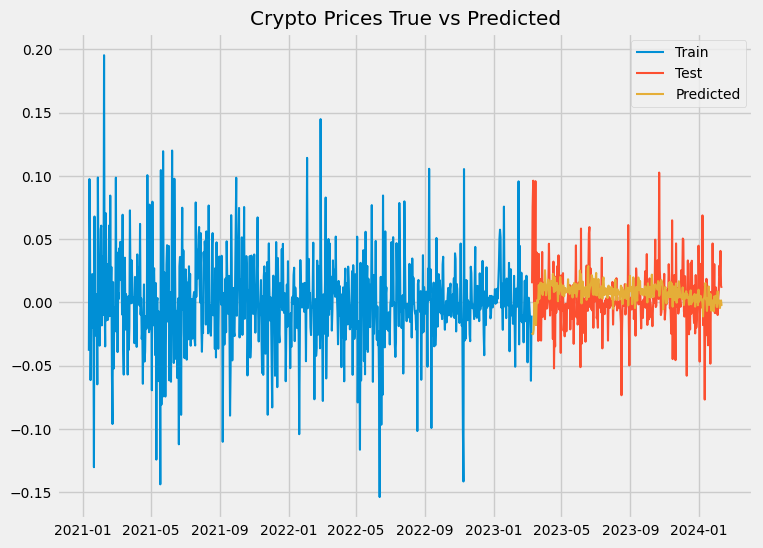

In [51]:
print(f"Ridge Train RMSE: {ridge_rmse_train:.2f}")
print(f"Ridge Test RMSE: {ridge_rmse_test:.2f}")
print(f"Ridge Train MAE: {ridge_mae_train:.2f}")
print(f"Ridge Test MAE: {ridge_mae_test:.2f}")
print(f"Ridge Train MAPE: {ridge_mape_train:.2f}")
print(f"Ridge Test MAPE: {ridge_mape_test:.2f}")
plot_predictions(df_train['returns_real'], df_test['returns_real'], df_test['returns_ridge'])

RandomForest Train RMSE: 0.02
RandomForest Test RMSE: 0.06
RandomForest Train MAE: 0.01
RandomForest Test MAE: 0.05
RandomForest Train MAPE: 2.03
RandomForest Test MAPE: 16.57


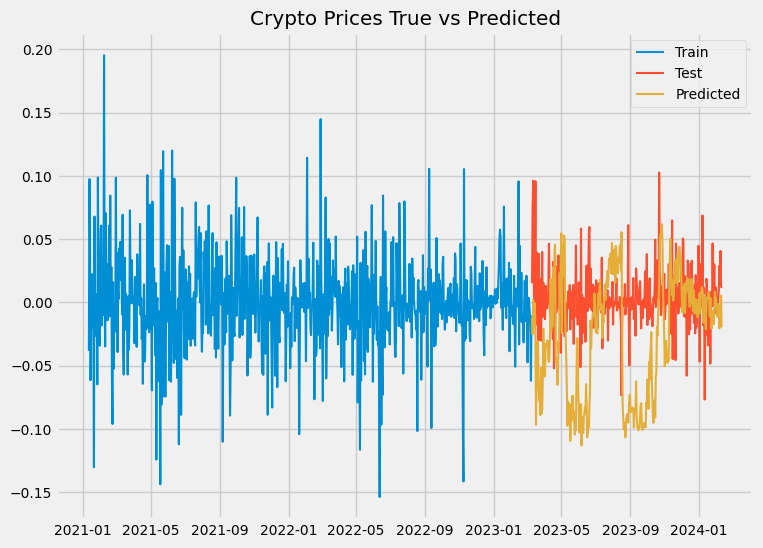

In [52]:
print(f"RandomForest Train RMSE: {rf_rmse_train:.2f}")
print(f"RandomForest Test RMSE: {rf_rmse_test:.2f}")
print(f"RandomForest Train MAE: {rf_mae_train:.2f}")
print(f"RandomForest Test MAE: {rf_mae_test:.2f}")
print(f"RandomForest Train MAPE: {rf_mape_train:.2f}")
print(f"RandomForest Test MAPE: {rf_mape_test:.2f}")
plot_predictions(df_train['returns_real'], df_test['returns_real'], df_test['returns_rf'])